### DATA PREPROCESSING

Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from glob import glob
import zipfile
from tqdm import tqdm
import cv2
from tensorflow.keras.utils import Sequence

Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/crowd dataset.zip'

extract_to = '/content'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content


converting .mat files to density maps

In [ ]:
def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    mat = sio.loadmat(mat_file)
    try:
        points = mat['image_info'][0, 0][0, 0][0]
    except:
        raise ValueError("Check the internal structure of your .mat file.")
    return points

Example results for density maps

Image: IMG_1.jpg
→ Number of people (points): 234
→ Sum of density map: 210.57



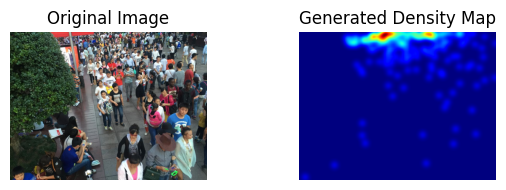

Image: IMG_10.jpg
→ Number of people (points): 230
→ Sum of density map: 207.34



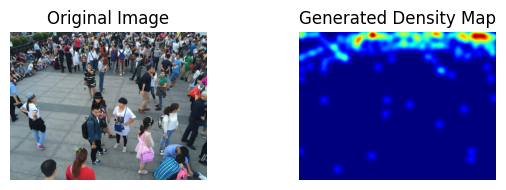

Image: IMG_100.jpg
→ Number of people (points): 206
→ Sum of density map: 203.86



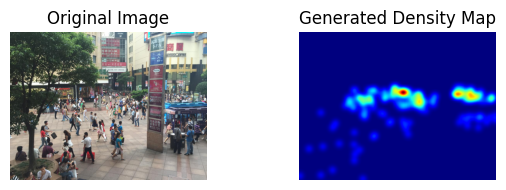

Image: IMG_101.jpg
→ Number of people (points): 83
→ Sum of density map: 80.14



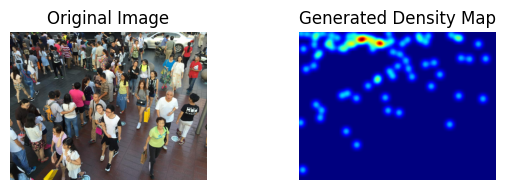

In [ ]:
image_dir = '/content/crowd dataset/train_data/images'
mat_dir = '/content/crowd dataset/train_data/ground_truth'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:4]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mat_path = os.path.join(mat_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_shape = img.shape[:2]  # (height, width)

    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(img_shape, points, sigma=15)

    print(f"Image: {img_file}")
    print(f"→ Number of people (points): {len(points)}")
    print(f"→ Sum of density map: {density_map.sum():.2f}\n")

    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title('Generated Density Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

saving all density maps in one folder  "ground_truth_density_map"

In [ ]:
input_dir = '/content/crowd dataset/train_data/ground_truth'
output_dir = '/content/crowd dataset/train_data/ground_truth_density_map'
os.makedirs(output_dir, exist_ok=True)

image_shape = (768, 1024)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Generating density maps"):
    mat_path = os.path.join(input_dir, file)
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(image_shape, points, sigma=15)

    output_path = os.path.join(output_dir, file.replace('.mat', '.npy'))
    np.save(output_path, density_map)

Generating density maps: 100%|██████████| 400/400 [00:05<00:00, 69.08it/s]


Making dataset for training

In [6]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(768, 1024), batch_size=4, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)  # Loads in BGR by default
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, (self.image_size[1], self.image_size[0]))  # Resize to (W, H)

            density_fname = 'GT_' + fname.replace('.jpg', '.npy')
            density_path = os.path.join(self.density_dir, density_fname)
            density_map = np.load(density_path).astype(np.float32)
            density_map = density_map[..., np.newaxis]  # Add channel dimension

            batch_images.append(img)
            batch_density_maps.append(density_map)

        return np.array(batch_images), np.array(batch_density_maps)


making training and validation sets

In [ ]:
train_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd dataset/train_data/images',
    density_dir='/content/crowd dataset/train_data/ground_truth_density_map',
    image_size=(768, 1024),
    batch_size=4,
    shuffle=True)

total_size = len(train_gen.image_filenames)
train_size = int(0.9 * total_size)
val_filenames = train_gen.image_filenames[train_size:]
train_filenames = train_gen.image_filenames[:train_size]

train_gen.image_filenames = train_filenames
val_gen = ImageDensityMapGenerator(
    image_dir=train_gen.image_dir,
    density_dir=train_gen.density_dir,
    image_size=train_gen.image_size,
    batch_size=train_gen.batch_size,
    shuffle=False)

val_gen.image_filenames = val_filenames

In [ ]:

images, density_maps = train_gen[0]

print("Input image batch shape:", images.shape)
print("Single input image shape:", images[0].shape)

print("Density map batch shape:", density_maps.shape)
print("Single density map shape:", density_maps[0].shape)


Input image batch shape: (4, 768, 1024, 3)
Single input image shape: (768, 1024, 3)
Density map batch shape: (4, 768, 1024, 1)
Single density map shape: (768, 1024, 1)


visualizing training set

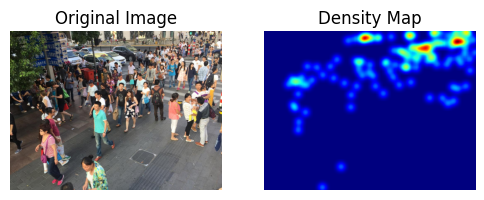

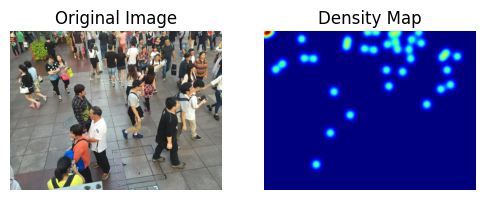

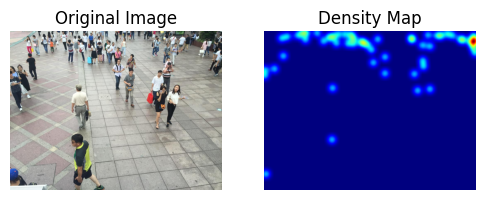

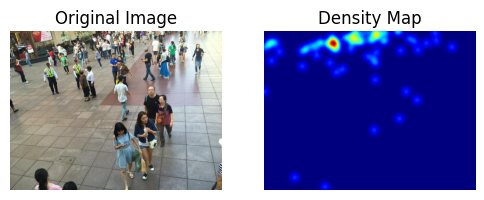

In [ ]:
import matplotlib.pyplot as plt

images, density_maps = train_gen[0]

for i in range(len(images)):
    plt.figure(figsize=(6, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_maps[i].squeeze(), cmap='jet')
    plt.title('Density Map')
    plt.axis('off')

    plt.show()

### MODEL TRAINING

model architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add, Multiply, Subtract

def VGG16_UNet_SkipOnly(input_shape=(768, 1024, 3)):
    inputs = Input(shape=input_shape)

    # Load pretrained VGG16
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Skip connections
    block1 = base_model.get_layer("block1_pool").output
    block2 = base_model.get_layer("block2_pool").output
    block3 = base_model.get_layer("block3_pool").output
    block4 = base_model.get_layer("block4_pool").output
    block5 = base_model.get_layer("block5_pool").output

    # Decoder
    x = Conv2DTranspose(512, 2, strides=2, padding="same")(block5)
    x = Add()([x, block4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(256, 2, strides=2, padding="same")(x)
    block3_proj = Conv2D(256, 1, padding='same')(block3)
    x = Add()([x, block3_proj])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, 2, strides=2, padding="same")(x)
    block2_proj = Conv2D(128, 1, padding='same')(block2)
    x = Add()([x, block2_proj])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, 2, strides=2, padding="same")(x)
    block1_proj = Conv2D(64, 1, padding='same')(block1)
    x = Add()([x, block1_proj])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    # Upsample to full size (768x1024)
    x = Conv2DTranspose(32, 2, strides=2, padding="same")(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    up5_out = Conv2D(1, 3, activation='relu', padding='same')(x)

    # IAB block
    iab = Conv2D(32, 1, activation='relu', padding='same')(up5_out)
    iab = Conv2D(32, 3, activation='relu', padding='same')(iab)
    iab = Conv2D(1, 3, activation='relu', padding='same')(iab)

    # Multiply + Subtract
    modulated = Multiply()([up5_out, iab])
    output = Subtract()([up5_out, modulated])

    # Apply 3 Conv layers with 64 channels each
    x = Conv2D(64, 3, activation='relu', padding='same')(output)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    # If you want final output to be single-channel again, add this:
    final_output = Conv2D(1, 1, activation='linear', padding='same')(x)

    model = Model(inputs, final_output)

    return model

# Build the model
model = VGG16_UNet_SkipOnly()
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 768, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 768, 1024, │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 768, 1024, │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 384, 512,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 384, 512,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 384, 512,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 192, 256,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 192, 256,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 192, 256,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 192, 256,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 96, 128,   │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 96, 128,   │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 96, 128,   │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 96, 128,   │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 48, 64,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 48, 64,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 48, 64,    │  2,359,808 │ block5_conv1[0][

 Total params: 22,909,539 (87.39 MB)

 Trainable params: 22,909,539 (87.39 MB)

 Non-trainable params: 0 (0.00 B)

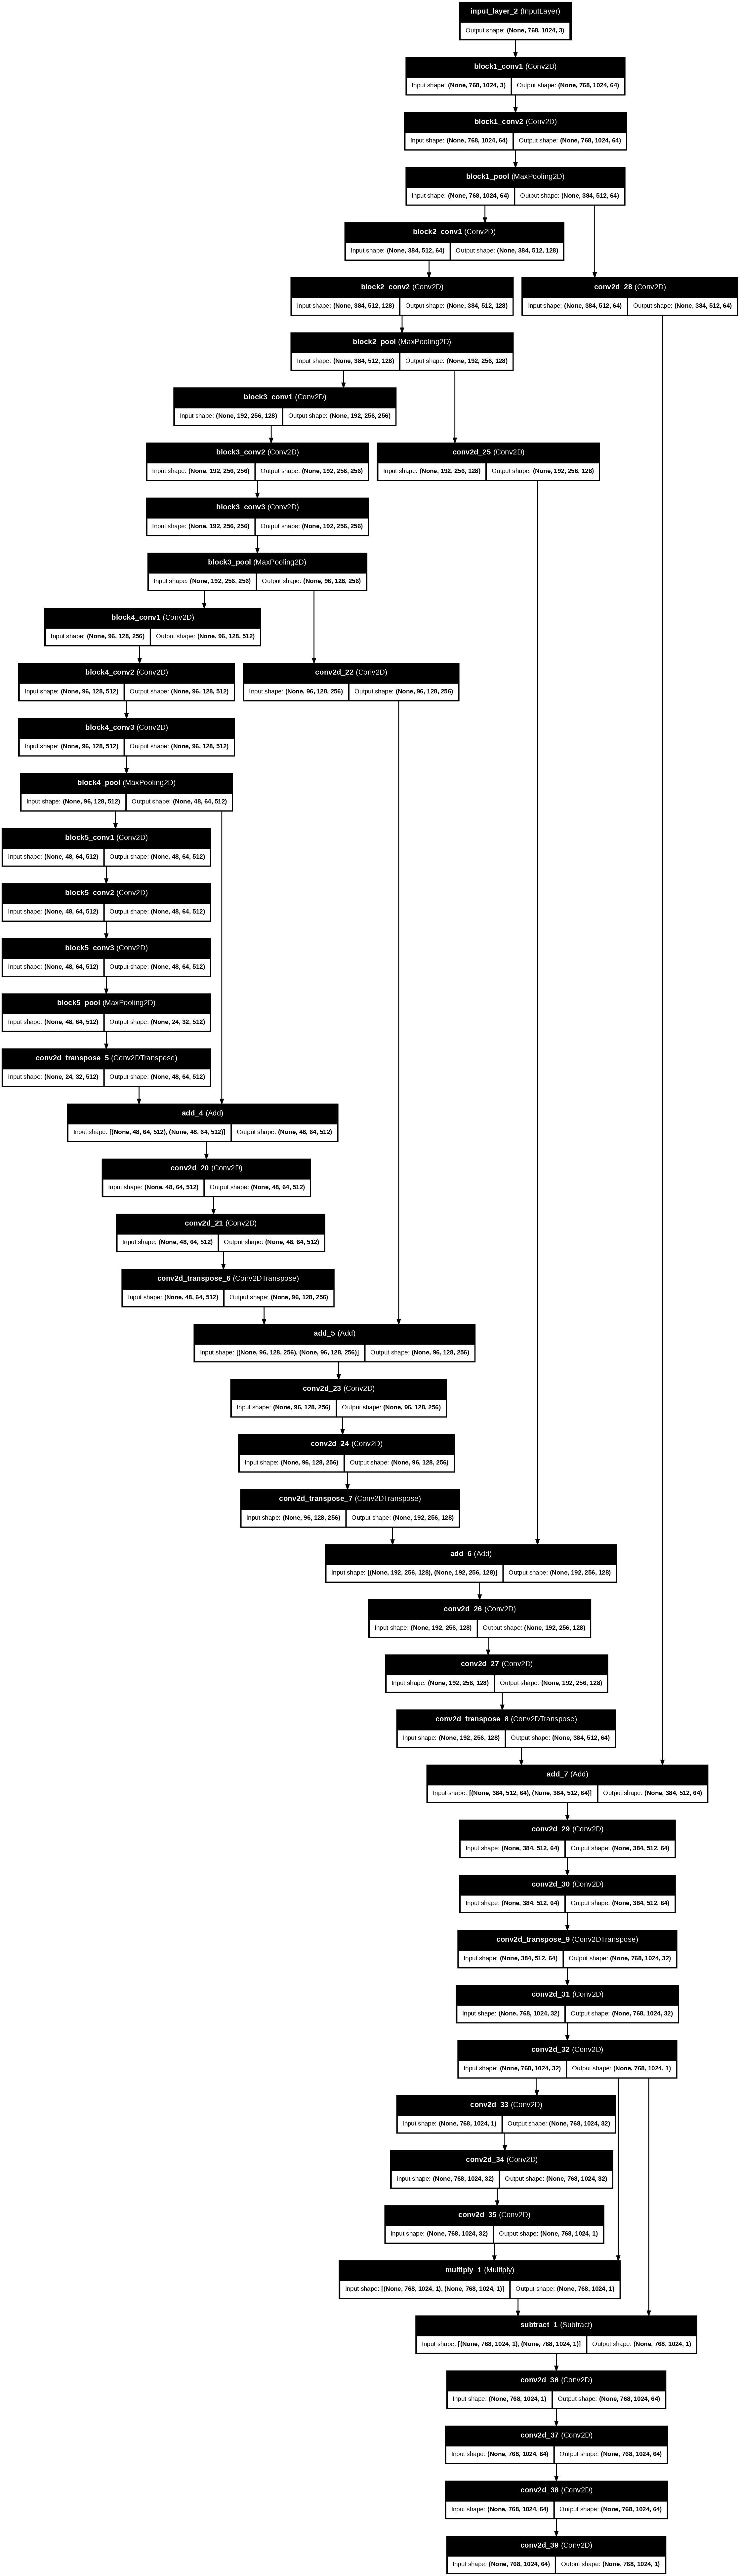

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming your model is created like this:
model = VGG16_UNet_SkipOnly()

# Plot and save to file
plot_model(
    model,
    to_file='vgg16_unet_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

training model

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Save to Drive
checkpoint_path = '/content/drive/My Drive/crowd_counting/best_model_1.h5'

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.2071 - mae: 0.4543

90/90 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - loss: 2.1885 - mae: 0.4512 - val_loss: 0.0091 - val_mae: 0.0397
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0069 - mae: 0.0334

90/90 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 0.0069 - mae: 0.0334 - val_loss: 0.0039 - val_mae: 0.0229
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0032 - mae: 0.0203

90/90 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 0.0032 - mae: 0.0202 - val_loss: 0.0022 - val_mae: 0.0150
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0019 - mae: 0.0136

90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 0.0019 - mae: 0.0136 - val_loss: 0.0014 - val_mae: 0.0103
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0012 - mae: 0.0093

90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 0.0012 - mae: 0.0093 - val_loss: 9.6760e-04 - val_mae: 0.0073
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 8.4612e-04 - mae: 0.0067

90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 8.4514e-04 - mae: 0.0067 - val_loss: 5.0853e-04 - val_mae: 0.0037
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.5030e-04 - mae: 0.0018

90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 2.4897e-04 - mae: 0.0018 - val_loss: 1.1256e-05 - val_mae: 2.9907e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.0739e-06 - mae: 2.7078e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - loss: 7.0578e-06 - mae: 2.7070e-04 - val_loss: 3.4401e-06 - val_mae: 2.5408e-04
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8013e-06 - mae: 2.5022e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 2.7965e-06 - mae: 2.5018e-04 - val_loss: 1.9826e-06 - val_mae: 2.4587e-04
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3864e-06 - mae: 2.3081e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - loss: 1.3860e-06 - mae: 2.3089e-04 - val_loss: 1.2728e-06 - val_mae: 2.4393e-04
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 9.0197e-07 - mae: 2.4317e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - loss: 9.0225e-07 - mae: 2.4313e-04 - val_loss: 9.4696e-07 - val_mae: 2.4168e-04
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 7.1591e-07 - mae: 2.2781e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 7.1596e-07 - mae: 2.2789e-04 - val_loss: 7.6919e-07 - val_mae: 2.4048e-04
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.8697e-07 - mae: 2.4103e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - loss: 5.8707e-07 - mae: 2.4099e-04 - val_loss: 6.3528e-07 - val_mae: 2.3696e-04
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.0904e-07 - mae: 2.4867e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 6.0794e-07 - mae: 2.4855e-04 - val_loss: 5.6949e-07 - val_mae: 2.3527e-04
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.9245e-07 - mae: 2.3207e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 4.9203e-07 - mae: 2.3209e-04 - val_loss: 5.1466e-07 - val_mae: 2.3830e-04
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.0024e-07 - mae: 2.2963e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 4.0037e-07 - mae: 2.2969e-04 - val_loss: 4.8430e-07 - val_mae: 2.4110e-04
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.6115e-07 - mae: 2.3321e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 3.6139e-07 - mae: 2.3323e-04 - val_loss: 4.6314e-07 - val_mae: 2.4075e-04
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8069e-07 - mae: 2.3241e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 3.8049e-07 - mae: 2.3243e-04 - val_loss: 4.5145e-07 - val_mae: 2.3867e-04
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.1584e-07 - mae: 2.5048e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - loss: 4.1507e-07 - mae: 2.5035e-04 - val_loss: 4.4142e-07 - val_mae: 2.3176e-04
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.1423e-07 - mae: 2.2399e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - loss: 3.1444e-07 - mae: 2.2405e-04 - val_loss: 4.3136e-07 - val_mae: 2.4245e-04
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.6588e-07 - mae: 2.4754e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - loss: 3.6542e-07 - mae: 2.4743e-04 - val_loss: 4.2302e-07 - val_mae: 2.3557e-04
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.2208e-07 - mae: 2.2529e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - loss: 3.2202e-07 - mae: 2.2537e-04 - val_loss: 4.1532e-07 - val_mae: 2.3505e-04
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.4221e-07 - mae: 2.4479e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 3.4187e-07 - mae: 2.4469e-04 - val_loss: 4.0906e-07 - val_mae: 2.2791e-04
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.4128e-07 - mae: 2.4695e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - loss: 3.4090e-07 - mae: 2.4682e-04 - val_loss: 4.0279e-07 - val_mae: 2.3213e-04
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8837e-07 - mae: 2.2704e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - loss: 2.8853e-07 - mae: 2.2710e-04 - val_loss: 3.9611e-07 - val_mae: 2.3498e-04
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.1166e-07 - mae: 2.3423e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 3.1153e-07 - mae: 2.3421e-04 - val_loss: 3.9099e-07 - val_mae: 2.3355e-04
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.7460e-07 - mae: 2.3233e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 2.7486e-07 - mae: 2.3236e-04 - val_loss: 3.8793e-07 - val_mae: 2.3811e-04
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8401e-07 - mae: 2.2834e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 2.8414e-07 - mae: 2.2838e-04 - val_loss: 3.8208e-07 - val_mae: 2.4035e-04
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.7784e-07 - mae: 2.3447e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 2.7802e-07 - mae: 2.3449e-04 - val_loss: 3.7857e-07 - val_mae: 2.3993e-04
Epoch 30/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.2355e-07 - mae: 2.2765e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 3.2321e-07 - mae: 2.2768e-04 - val_loss: 3.7504e-07 - val_mae: 2.5281e-04
Restoring model weights from the end of the best epoch: 30.


In [ ]:
model = VGG16_UNet_SkipOnly()
model.load_weights('/content/drive/My Drive/crowd_counting/best_model.h5')
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=30,  # Optional but good for logs
    epochs=50,
    callbacks=callbacks
)

Epoch 31/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.1382e-07 - mae: 2.4603e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 3.1362e-07 - mae: 2.4594e-04 - val_loss: 3.2415e-07 - val_mae: 2.4241e-04
Epoch 32/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - loss: 2.8095e-07 - mae: 2.3748e-04 - val_loss: 3.4995e-07 - val_mae: 3.5120e-04
Epoch 33/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 3.6220e-07 - mae: 2.5445e-04 - val_loss: 3.3284e-07 - val_mae: 3.0170e-04
Epoch 34/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.7007e-07 - mae: 2.3934e-04 - val_loss: 3.2567e-07 - val_mae: 2.6410e-04
Epoch 35/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.4834e-07 - mae: 2.2286e-04 - val_loss: 3.3772e-07 - val_mae: 3.1852e-04
Epoch 36/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 3.2013e-07 - mae: 2.4874e-04 - val_loss: 3.2477e-07 - val_mae: 2.5518e-04
Epoch 37/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 3.5760e-07 - mae: 2.5914e-04 - val_loss: 3.2563e-07 - val_mae: 2.6404e-04
Epoch 38/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.5359e-07 - m

In [ ]:
model = VGG16_UNet_SkipOnly()
model.load_weights('/content/drive/My Drive/crowd_counting/best_model.h5')
from tensorflow.keras.optimizers import Adam
callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
]
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='mse',
    metrics=['mae']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=38,
    epochs=50,
    callbacks=callbacks
)

Epoch 39/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8474e-07 - mae: 2.5373e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 3.8369e-07 - mae: 2.5351e-04 - val_loss: 3.2431e-07 - val_mae: 2.5033e-04
Epoch 40/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.4553e-07 - mae: 2.2960e-04 - val_loss: 3.3199e-07 - val_mae: 2.9941e-04
Epoch 41/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.3809e-07 - mae: 2.4654e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 3.3754e-07 - mae: 2.4641e-04 - val_loss: 3.2382e-07 - val_mae: 2.3555e-04
Epoch 42/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 3.2379e-07 - mae: 2.3969e-04 - val_loss: 3.2649e-07 - val_mae: 2.7259e-04
Epoch 43/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8042e-07 - mae: 2.3751e-04

90/90 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 2.8050e-07 - mae: 2.3747e-04 - val_loss: 3.2375e-07 - val_mae: 2.3760e-04
Epoch 44/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.9348e-07 - mae: 2.3666e-04 - val_loss: 3.2506e-07 - val_mae: 2.1389e-04
Epoch 45/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 3.2104e-07 - mae: 2.3523e-04 - val_loss: 3.2420e-07 - val_mae: 2.5189e-04
Epoch 46/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 3.1256e-07 - mae: 2.3846e-04 - val_loss: 3.2543e-07 - val_mae: 2.1080e-04
Epoch 47/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.7876e-07 - mae: 2.3084e-04 - val_loss: 3.2609e-07 - val_mae: 2.7023e-04
Epoch 48/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.7078e-07 - mae: 2.3536e-04 - val_loss: 3.2386e-07 - val_mae: 2.2876e-04
Epoch 49/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 2.5178e-07 - mae: 2.3516e-04 - val_loss: 3.3096e-07 - val_mae: 1.8465e-04
Epoch 50/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 2.9599e-07 - m

Plotting loss function

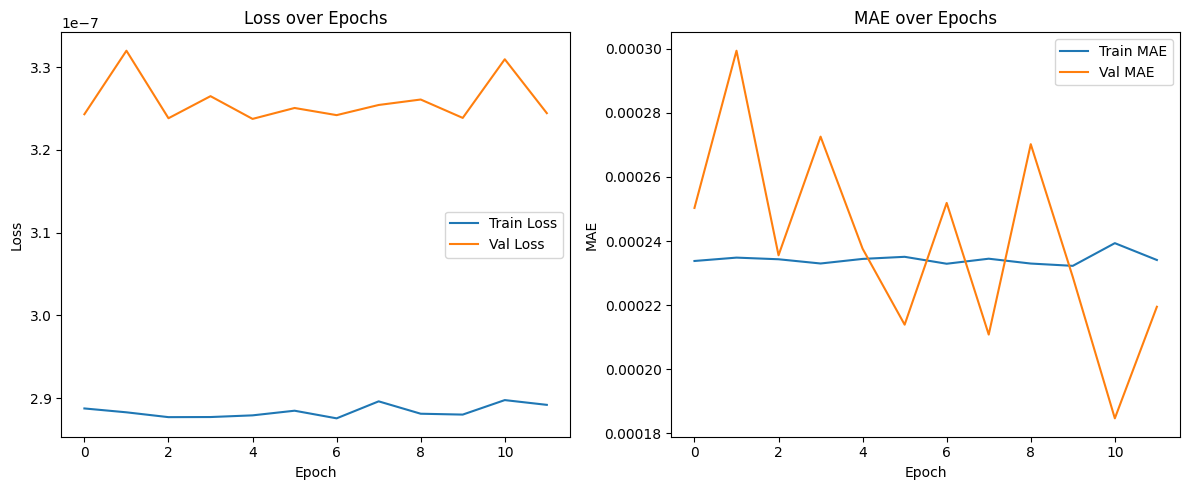

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE (only if you're tracking it)
if 'mae' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Path to the zip file
zip_path = '/content/density maps test data.zip'

# Destination directory where the files will be extracted
extract_to = '/content/density maps test dat'

# Create the destination folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content/density maps test dat


In [ ]:
# 👇 Create test generator (no shuffling)
test_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd dataset/test_data/images',
    density_dir='/content/density maps test dat',
    image_size=(768, 1024),
    batch_size=1,
    shuffle=False
)

# 🔮 Predict density maps
predictions = model.predict(test_gen, verbose=1)

# 📏 Calculate MAE on total count per image
mae_total_count = 0.0
n_samples = len(test_gen)

for i in range(n_samples):
    # True density map
    _, true_density = test_gen[i]
    true_count = np.sum(true_density)

    # Predicted density map
    pred_density = predictions[i]
    pred_count = np.sum(pred_density)

    # Accumulate MAE
    mae_total_count += abs(pred_count - true_count)

# ✅ Final MAE
mae_total_count /= n_samples
print(f"📊 Test MAE (Total Count): {mae_total_count:.2f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step
📊 Test MAE (Total Count): 64.84


In [5]:
zip_path = '/content/crowd dataset.zip'

extract_to = '/content'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content


In [4]:
import os
zip_path = '/content/density maps training data.zip'

extract_to = '/content/train density'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content/train density


In [7]:
#  Create test generator (no shuffling)
from tensorflow.keras.models import load_model
model = load_model('/content/best_model.h5', compile=False)

train_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd dataset/train_data/images',
    density_dir='/content/train density',
    image_size=(768, 1024),
    batch_size=1,
    shuffle=False
)

# Predict density maps
predictions = model.predict(train_gen, verbose=1)

#  Calculate MAE on total count per image
mae_total_count = 0.0
n_samples = len(train_gen)

for i in range(n_samples):
    # True density map
    _, true_density = train_gen[i]
    true_count = np.sum(true_density)

    # Predicted density map
    pred_density = predictions[i]
    pred_count = np.sum(pred_density)

    # Accumulate MAE
    mae_total_count += abs(pred_count - true_count)

# ✅ Final MAE
mae_total_count /= n_samples
print(f"Train MAE (Total Count): {mae_total_count:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step
📊 Train MAE (Total Count): 84.81
